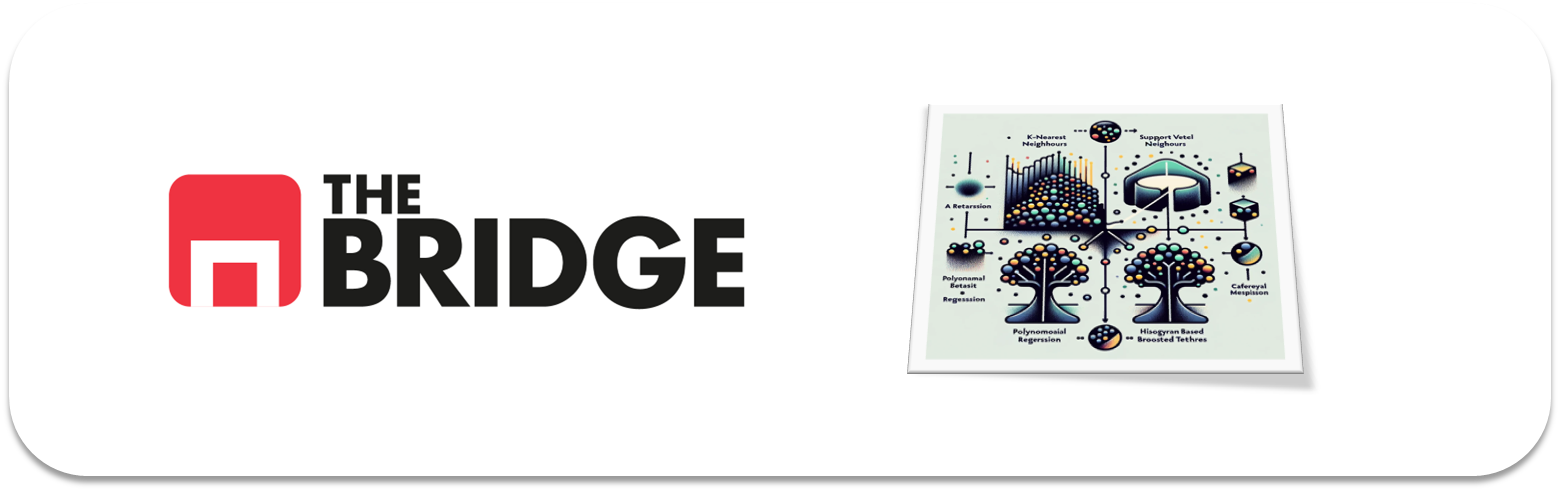

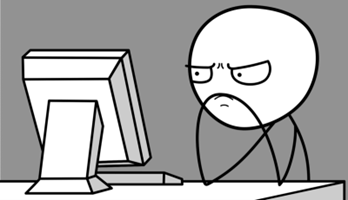

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

MAE y RMSE

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [3]:
df = pd.read_csv("./data/air_contamination.csv")
df

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8986,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
8987,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
8988,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
8989,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [5]:
target = "PT08.S5(O3)"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       8991 non-null   int64  
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        8991 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        8991 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 913.3 KB


### Ejercicio 3: Split

Haz el split en train y test.

In [6]:
train, test = train_test_split(df, test_size=.2, random_state=42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

(2,)


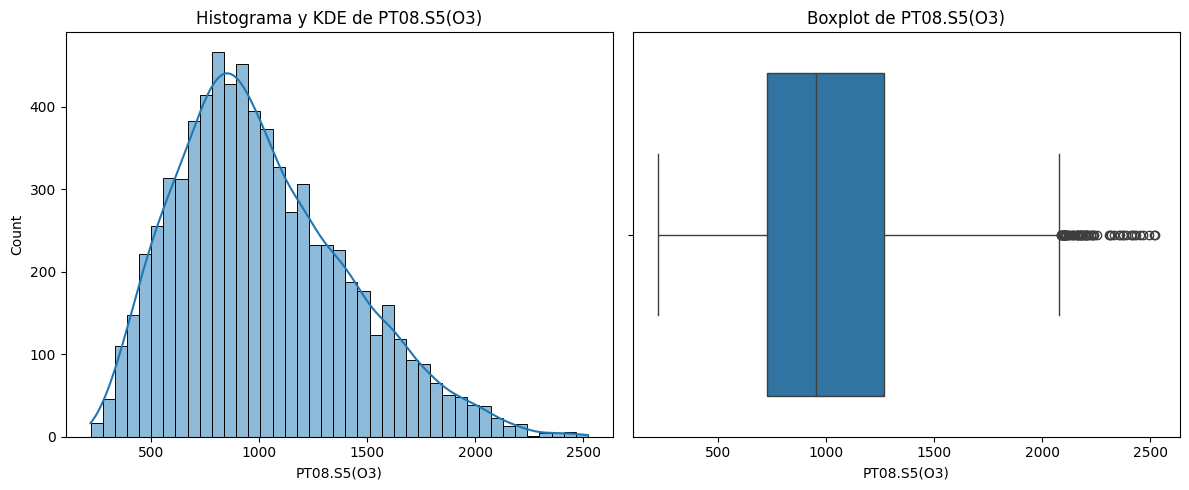

In [8]:
bt.plot_combined_graphs(train, [target])

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [13]:
corr = train.corr(numeric_only=True)
abs(corr[target]).sort_values(ascending=False)

PT08.S5(O3)      1.000000
PT08.S1(CO)      0.901005
PT08.S2(NMHC)    0.879959
C6H6(GT)         0.864269
PT08.S3(NOx)     0.794185
NOx(GT)          0.623100
PT08.S4(NO2)     0.590688
NO2(GT)          0.337581
RH               0.133955
CO(GT)           0.128110
NMHC(GT)         0.110077
AH               0.069113
T                0.032899
Name: PT08.S5(O3), dtype: float64

<Axes: >

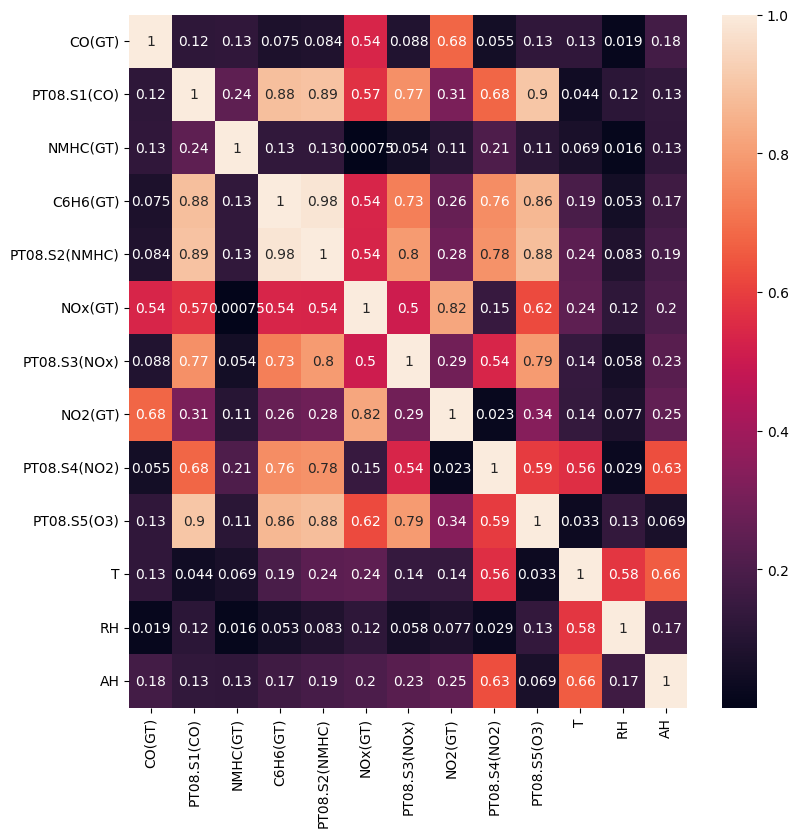

In [19]:
plt.figure(figsize=(9,9))
sns.heatmap(abs(corr), annot=True)

alta corr con target
- pt co: benzè, nmhc
- nox gt
- pt nox: nmhc, pt co
- pt no2

me quito benceno y nmhc

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [20]:
train.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [23]:
features = ['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)','NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [29]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [30]:
rf = RandomForestRegressor()
lgbm = LGBMRegressor(verbose=-1)
xgb = XGBRegressor()

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [32]:
print(-(cross_val_score(rf, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")).mean())
print(-(cross_val_score(lgbm, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")).mean())
print(-(cross_val_score(xgb, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")).mean())

0.31397637473605844
2.7257917518572468
2.8967022231068227


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [34]:
param_grid = {
    "n_estimators": [100,200,400], # 
    "max_depth": [1,5,10],
    "min_samples_leaf": [1,10,20],
    "max_features": ["sqrt","log2",None]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 10, 20],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_mean_absolute_error')

In [36]:
train_pred = grid_search.best_estimator_.predict(X_train)

print("MAE:", mean_absolute_error(y_train, train_pred))
print("RSME:", np.sqrt(mean_squared_error(y_train, train_pred)))

MAE: 0.1724401469223387
RSME: 0.4412678306667727


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

error max de 100

In [37]:
test_pred = grid_search.best_estimator_.predict(X_test)

print("MAE:", mean_absolute_error(y_test, test_pred))
print("RSME:", np.sqrt(mean_squared_error(y_test, test_pred)))

MAE: 0.31707636107396686
RSME: 1.4124541653494442


### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

In [38]:

def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()


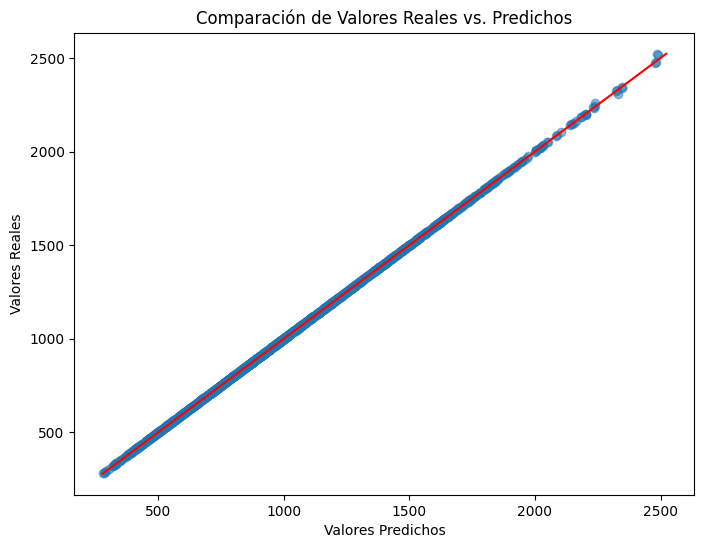

In [39]:
plot_predictions_vs_actual(y_test, test_pred)

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.

In [40]:
import pickle

# Creamos el directorio si no existe
os.makedirs("models", exist_ok= True)


# Guardar el modelo en un archivo
with open('o3_pred.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)